In [3]:
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import os

import keras.backend as K
import keras.utils

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation, Add, Conv2D, Conv2DTranspose, concatenate, Cropping2D, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import cv2 as cv
import pandas as pd
import numpy as np
import os


'''Train / Test Data Import******************************************************************************************'''
data_dir = "/content/drive/MyDrive/Dataset/facial-keypoints-detection"
train_dir = "train"
train_csv = "training.csv"
test_dir = "test"
test_csv = "test.csv"

df_train = pd.read_csv(os.path.join(data_dir, train_csv))
df_test = pd.read_csv(os.path.join(data_dir, test_csv))

'''******************************************************************************************************************'''


'''# of Train / Test Images******************************************************************************************'''

n_train = df_train['Image'].size
n_test = df_test['Image'].size

print("# of training images: {}".format(n_train))
print("# of test images: {}".format(n_test))

'''******************************************************************************************************************'''


'''Save Train & Test Images to External Folder***********************************************************************'''


def save_images(img_arr, img_type, img_dir):

    for i, img in enumerate(img_arr):
        img = np.fromstring(img, dtype=int, sep=' ')
        img = np.reshape(img, newshape=(96, 96))

        fn = img_type + str(i) + ".png"

        cv.imwrite(os.path.join(data_dir, img_dir, fn), img)

        print("Saving {} to {}".format(fn, os.path.join(data_dir, img_dir)))


train_arr = df_train['Image'].tolist()
test_arr = df_test['Image'].tolist()

save_images(train_arr, img_type="train", img_dir=train_dir)
save_images(test_arr, img_type="test", img_dir=test_dir)

'''******************************************************************************************************************'''


'''Find Image Indices with 15 Keypoints******************************************************************************'''


df_kp = df_train.iloc[:, 0:30]
counter = 0
idxs = []

id_dict = {}
kp_dict = {}

for i in range(n_train):

    if True in df_train.iloc[i, 0:30].isna().values:
        continue
    else:
        counter += 1
        idxs.append(i)

        # image
        img = df_train.iloc[i, 30]
        img = np.fromstring(img, dtype=float, sep=' ')
        img = np.reshape(img, newshape=(96, 96))/ 255
        id_dict[i] = img

        # keypoints
        kp = df_kp.iloc[i].values.tolist()
        kp_dict[i] = kp

print("# of Images with 15 keypoints = {}".format(counter))

'''******************************************************************************************************************'''

Streaming output truncated to the last 5000 lines.
Saving train3833.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3834.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3835.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3836.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3837.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3838.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3839.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3840.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3841.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3842.png to /content/drive/MyDrive/Dataset/facial-keypoints-detection/train
Saving train3843.png to /content/drive/MyDrive/Dataset/facial-keypoin

'******************************************************************************************************************'

## Mask Generator

In [26]:
class MaskGenerator(keras.utils.Sequence):

    def __init__(self, directory, idxs, img_dict, labels_dict,
                 target_size=(96,96), batch_size=32, augment=True,
                 transform_dict = None, shuffle=True):

        self.directory = directory
        self.idxs = idxs
        self.img_dict = img_dict
        self.labels_dict = labels_dict
        self.transform_dict = transform_dict
        self.target_size = target_size
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    # shuffle indices at the end of each epoch
    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.idxs)

    # return number of batches per epoch
    def __len__(self):

        if self.augment is True:
            multiplier = 5
        else:
            multiplier = 1

        return int(np.floor(len(self.idxs) * multiplier / self.batch_size))

    # check if transformed point is located within image boundaries
    def _checkBoundaries(self, p):

        # x dimension
        if p[0] < 0:
            px = 0
        elif p[0] > self.target_size[0]:
            px = self.target_size[0]
        else:
            px = p[0]

        # y dimension
        if p[1] < 0:
            py = 0
        elif p[1] > self.target_size[1]:
            py = self.target_size[1]
        else:
            py = p[1]

        return (int(px), int(py))

    # apply shifts, rotations, scaling and flips to original image and keypoints
    def _transform_image(self, img, keypoints):

        aug_keypoints = []

        c = (img.shape[0] // 2, img.shape[1] // 2)

        if self.transform_dict['Flip']:
            flip = random.choice([True, False])
            if flip:
                img = cv.flip(img, flipCode=1)

        if self.transform_dict['Rotate']:

            if self.transform_dict['Scale']:
                s = random.uniform(0.7, 1.0)
            else:
                s = 1.0

            r = random.randint(-10, 10)
            M_rot = cv.getRotationMatrix2D(center=(img.shape[0] // 2, img.shape[1] // 2), angle=r, scale=s)
            img = cv.warpAffine(img, M_rot, (img.shape[0], img.shape[1]), borderMode=cv.BORDER_CONSTANT, borderValue=1)

        if self.transform_dict['Shift']:
            tx = random.randint(-20, 20)
            ty = random.randint(-20, 20)
            M_shift = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
            img = cv.warpAffine(img, M_shift, (img.shape[0], img.shape[1]),
                                borderMode=cv.BORDER_CONSTANT, borderValue=1)

        '''print("\nHorizontal Flip = {}".format(flip))
        print("Horizontal Shift = {}".format(tx))
        print("Vertical Shift = {}".format(ty))
        print("Isotropic Scale Factor = {}".format(s))
        print("Rotation = {}".format(r))'''

        # transform keypoints
        c = (img.shape[0] // 2, img.shape[1] // 2)

        for i in range(0, len(keypoints) - 1, 2):

            px = keypoints[i]
            py = keypoints[i+1]
            p = np.array([px, py, 1], dtype=int)

            # apply flip
            if self.transform_dict['Flip'] and flip:
                p[0] = c[0] - (p[0] - c[0])

            # apply rotation
            if self.transform_dict['Rotate']:
                p = np.dot(M_rot, p)

            # apply horizontal / vertical shifts
            if self.transform_dict['Shift']:
                p[0] += tx
                p[1] += ty

            p = self._checkBoundaries(p)

            aug_keypoints.append(p[0])
            aug_keypoints.append(p[1])

        return img, aug_keypoints

    # load image from disk
    def _load_image(self, fn):

        img = cv.imread(filename=os.path.join(self.directory, fn))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img = np.float32(img) / 255

        return img

    # apply gaussian kernel to image
    def _gaussian(self, xL, yL, sigma, H, W):

        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel

    # convert original image to heatmap
    def _convertToHM(self, img, keypoints, sigma=5):

        H = img.shape[0]
        W = img.shape[1]
        nKeypoints = len(keypoints)

        img_hm = np.zeros(shape=(H, W, nKeypoints // 2), dtype=np.float32)

        for i in range(0, nKeypoints // 2):
            x = keypoints[i * 2]
            y = keypoints[1 + 2 * i]

            channel_hm = self._gaussian(x, y, sigma, H, W)

            img_hm[:, :, i] = channel_hm

        img_hm = np.reshape(img_hm, newshape=(img_hm.shape[0]*img_hm.shape[1]*nKeypoints // 2, 1))

        return img_hm

    # generate batches of scaled images and bounding boxes
    def _data_generation(self, idxs):

        x = []
        y = []

        for idx in idxs:
            img = self._load_image(self.img_dict[idx])
            keypoints = self.labels_dict[idx]

            if self.augment is True and self.transform_dict:
                img, keypoints = self._transform_image(img, keypoints)

            img = np.reshape(img, (96, 96, 1))
            img_hm = self._convertToHM(img, keypoints)

            x.append(img)
            y.append(img_hm)

        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

    # return indices for train batches
    def _get_train_idxs(self, idx):

        # number of batches in original train set
        N = int(np.floor(len(self.idxs) / self.batch_size))

        # idx exceeds original image indices
        if idx > N:

            # reset start idx
            if idx % N == 0:
                reset_idx = 0 #((idx - 1) % N) + 1
            else:
                reset_idx = idx % N - 1

            start = reset_idx * self.batch_size

            # end idx
            if (reset_idx + 1) * self.batch_size > len(self.idxs):
                end = len(self.idxs)
            else:
                end = (reset_idx + 1) * self.batch_size

        # idx is within in original train set
        else:
            start = idx * self.batch_size
            end = (idx + 1) * self.batch_size

        # print(start)
        # print(end)

        return start, end

    # return indices for val batches
    def _get_val_idxs(self, idx):

        if (idx + 1) * self.batch_size > len(self.idxs):
            end = len(self.idxs)
        else:
            end = (idx + 1) * self.batch_size

        return idx * self.batch_size, end

    # return batch of image data and labels
    def __getitem__(self, idx):

        if self.augment is True:
            start_batch_idx, end_batch_idx = self._get_train_idxs(idx)
        else:
            start_batch_idx, end_batch_idx = self._get_val_idxs(idx)

        idxs = self.idxs[start_batch_idx:end_batch_idx]
        batch_x, batch_y = self._data_generation(idxs)

        return batch_x, batch_y

## Visualize Masks

In [27]:
def show_masks(batch_imgs, batch_gt_masks, nrows, ncols, include_preds= False, predictions=None):

    if not include_preds:
        nrows -= 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    r = -1

    for c in range(ncols):

        # original image
        img = batch_imgs[c]
        img = np.reshape(img, newshape=(96,96))
        img = np.stack([img,img,img], axis=-1)

        # ground-truth mask
        gt_mask = batch_gt_masks[c]
        gt_mask = np.reshape(gt_mask, newshape=(96,96,15))
        gt_mask = np.sum(gt_mask, axis=-1)

        axes[0, c].imshow(img)
        axes[1, c].imshow(gt_mask)

        # prediction mask
        if include_preds:
            pred_mask = predictions[c]
            pred_mask = np.reshape(pred_mask, newshape=(96,96, 15))
            pred_mask = np.sum(pred_mask, axis=-1)
            axes[2, c].imshow(pred_mask)

    plt.show()

## Load Training Data

In [28]:
data_dir = "/content/drive/MyDrive/Dataset/facial-keypoints-detection"
train_dir = "train"
train_csv = "training.csv"
test_dir = "test"
test_csv = "test.csv"

df_train = pd.read_csv(os.path.join(data_dir, train_csv))
df_test = pd.read_csv(os.path.join(data_dir, test_csv))

n_train = df_train['Image'].size
n_test = df_test['Image'].size

df_kp = df_train.iloc[:,0:30]

idxs = []

img_dict = {}
kp_dict = {}

for i in range(n_train):

    if True in df_train.iloc[i, 0:30].isna().values:
        continue
    else:
        idxs.append(i)

        img_dict[i] = "train"+str(i)+".png"

        # keypoints
        kp = df_kp.iloc[i].values.tolist()
        kp_dict[i] = kp

## Split Data Into Train / Val Sets


# of Training Images: 192
# of Val Images: 22

# of training batches= 12
# of validation batches= 1
(16, 96, 96, 1)
(16, 138240, 1)


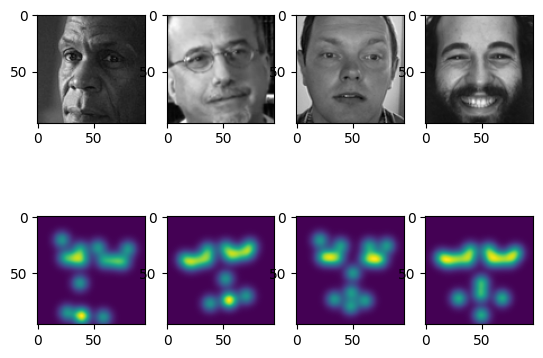

(16, 96, 96, 1)
(16, 138240, 1)


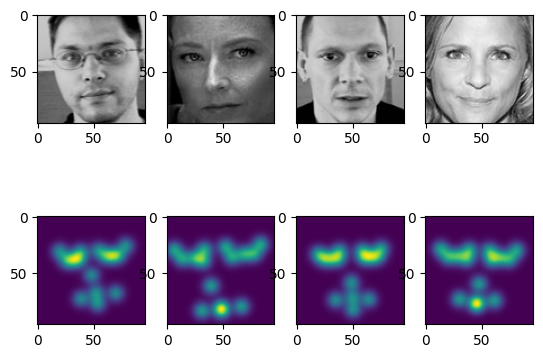

In [29]:
random.shuffle(idxs)

subset = int(0.1*len(idxs))

cutoff_idx = int(0.9*subset)
train_idxs = idxs[0:cutoff_idx]
val_idxs = idxs[cutoff_idx:subset]

print("\n# of Training Images: {}".format(len(train_idxs)))
print("# of Val Images: {}".format(len(val_idxs)))

transform_dict = {"Flip": False, "Shift": False, "Scale": False, "Rotate": False}

train_gen = MaskGenerator(os.path.join(data_dir, train_dir),
                              train_idxs,
                              img_dict,
                              kp_dict,
                              transform_dict=transform_dict,
                              augment=False,
                              batch_size=16)

val_gen = MaskGenerator(os.path.join(data_dir, train_dir),
                            val_idxs,
                            img_dict,
                            kp_dict,
                            augment=False,
                            batch_size=16)

print("\n# of training batches= %d" % len(train_gen))
print("# of validation batches= %d" % len(val_gen))


train_imgs, train_masks = train_gen[0]
print(train_imgs.shape)
print(train_masks.shape)
show_masks(train_imgs[0:4], train_masks[0:4], nrows=3, ncols=4)

val_imgs, val_masks= val_gen[0]
print(val_imgs.shape)
print(val_masks.shape)
show_masks(val_imgs[0:4], val_masks[0:4], nrows=3, ncols=4)

## Architecture

### UNet

In [ ]:
def UNET(input_shape):
    def downsample_block(x, block_num, n_filters, pooling_on=True):

        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)
        skip = x

        if pooling_on is True:
            x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="Block" + str(block_num) + "_Pool1")(x)

        return x, skip

    def upsample_block(x, skip, block_num, n_filters):

        # if x.shape[1] * 2 != skip.shape[1]:
            # dw = int(skip.shape[1] - (x.shape[1] * 2)) // 2
            # skip = Cropping2D(cropping=((dw, dw), (dw, dw)), name="Block" + str(block_num) + "_Crop1")(skip)

        x = Conv2DTranspose(n_filters, kernel_size=(2, 2), strides=2, padding='valid', activation='relu',
                            name="Block" + str(block_num) + "_ConvT1")(x)
        x = concatenate([x, skip], axis=-1, name="Block" + str(block_num) + "_Concat1")
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)

        return x

    input = Input(input_shape, name="Input")

    # downsampling
    x, skip1 = downsample_block(input, 1, 64)
    x, skip2 = downsample_block(x, 2, 128)
    x, skip3 = downsample_block(x, 3, 256)
    x, skip4 = downsample_block(x, 4, 512)
    x, _ = downsample_block(x, 5, 1024, pooling_on=False)

    # upsampling
    x = upsample_block(x, skip4, 6, 512)
    x = upsample_block(x, skip3, 7, 256)
    x = upsample_block(x, skip2, 8, 128)
    x = upsample_block(x, skip1, 9, 64)

    output = Conv2D(15, kernel_size=(1, 1), strides=1, padding='valid', activation='linear', name="output")(x)
    output = Reshape(target_shape=(96*96*15,1))(output)

    model = Model(inputs=input, outputs=output, name="Output")

    return model


unet = UNET(input_shape=(96, 96, 1))
print(unet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
Block1_Conv1 (Conv2D)           (None, 96, 96, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Block1_Conv2 (Conv2D)           (None, 96, 96, 64)   36928       Block1_Conv1[0][0]               
__________________________________________________________________________________________________
Block1_Pool1 (MaxPooling2D)     (None, 48, 48, 64)   0           Block1_Conv2[0][0]               
__________________________________________________________________________________________________
Block2_Con

### FCN-8

In [ ]:
def conv_block(x, nconvs, n_filters, block_name, wd=None):
    for i in range(nconvs):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   kernel_regularizer=wd, name=block_name + "_conv" + str(i + 1))(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name=block_name + "_pool")(x)

    return x


def FCN8(input_shape):
    input = Input(shape=input_shape, name="Input")

    # Block 1
    x = conv_block(input, nconvs=2, n_filters=64, block_name="block1")

    # Block 2
    x = conv_block(x, nconvs=2, n_filters=128, block_name="block2")

    # Block 3
    pool3 = conv_block(x, nconvs=3, n_filters=256, block_name="block3")

    # Block 4
    pool4 = conv_block(pool3, nconvs=3, n_filters=512, block_name="block4")

    # Block 5
    x = conv_block(pool4, nconvs=3, n_filters=512, block_name="block5")

    # convolution 6
    x = Conv2D(4096, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv6")(x)

    # convolution 7
    x = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv7")(x)

    # upsampling
    preds_pool3 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool3")(pool3)
    preds_pool4 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool4")(pool4)
    up_pool4 = Conv2DTranspose(filters=15, kernel_size=2, strides=2, activation="relu", name="ConvT_pool4")(preds_pool4)
    up_conv7 = Conv2DTranspose(filters=15, kernel_size=4, strides=4, activation="relu", name="ConvT_conv7")(x)

    fusion = Add()([preds_pool3, up_pool4, up_conv7])

    output = Conv2DTranspose(filters=15, kernel_size=8, strides=8, activation='relu', name="convT_fusion")(fusion)
    output = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="linear", name="output")(output)
    output = Reshape(target_shape=(96*96*15, 1))(output)

    model = Model(inputs=input, outputs=output, name="FCN8")

    return model


fcn = FCN8(input_shape=(96, 96, 1))

print(fcn.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

## Training

In [ ]:
def jaccard(ytrue, ypred, smooth=1e-5):

    intersection = K.sum(K.abs(ytrue*ypred), axis=-1)
    union = K.sum(K.abs(ytrue)+K.abs(ypred), axis=-1)
    jac = (intersection + smooth) / (union-intersection+smooth)

    return K.mean(jac)


In [ ]:
def mean_squared_error(y_true, y_pred):
    channel_loss = K.sum(K.square(y_pred - y_true), axis=-1)
    total_loss = K.mean(channel_loss, axis=-1)
    print(total_loss.shape)
    return total_loss

In [ ]:
def create_callbacks(wts_fn, lr_decay = 0.25, patience=5, enable_save_wts = True):

    cbks = []

    # learning rate
    '''lr_schedule = ReduceLROnPlateau(monitor='val_loss',
                                    factor=lr_decay,
                                    patience=patience,
                                    min_lr=1e-6,
                                    verbose=1)
    cbks.append(lr_schedule)'''

    # early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience=patience)
    cbks.append(early_stopper)

    # model checkpoint
    if enable_save_wts is True:
        model_chpt = ModelCheckpoint(filepath=wts_fn,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_weights_only=True,
                                     save_best_only=True,
                                     period=patience)

        cbks.append(model_chpt)

    return cbks


'''def findLearningRate(model, model_name):

    print("{}".format(model_name))
    lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

    # find initial learning rate
    for lr in lrs:
        print("Learning Rate: {}".format(lr))
        optim = Adam(lr=lr)
        model.compile(loss='binary_crossentropy', optimizer=optim, metrics=None)
        model.fit_generator(generator=train_gen,
                            epochs=1)'''


def trainModel(model, model_name, loss_type, n_epochs, lr, load_saved_wts = False):

    wts_fn = model_name + ".h5"

    if load_saved_wts is True:
        model.load_weights(wts_fn)

    optim = RMSprop(lr=lr)
    # optim = Adam(lr=lr)
    cbks = create_callbacks(wts_fn)
    model.compile(loss="mean_squared_error", optimizer=optim, metrics=None)
    model.fit_generator(generator=train_gen,
                        validation_data=val_gen,
                        epochs=n_epochs,
                        callbacks=cbks)

    return model

### Train Models

In [ ]:
loss_type = "mse"
# loss_type = "categorical_crossentropy"

In [ ]:
unet = trainModel(unet, "unet1", loss_type, n_epochs=75, lr=1e-3, load_saved_wts=False)

Epoch 1/75
12/12 [==============================] - 25s 2s/step - loss: 0.0086 - val_loss: 0.0082
Epoch 2/75
12/12 [==============================] - 23s 2s/step - loss: 0.0082 - val_loss: 0.0083
Epoch 3/75
12/12 [==============================] - 25s 2s/step - loss: 0.0082 - val_loss: 0.0082
Epoch 4/75
12/12 [==============================] - 24s 2s/step - loss: 0.0082 - val_loss: 0.0081
Epoch 5/75
12/12 [==============================] - 23s 2s/step - loss: 0.0082 - val_loss: 0.0082

Epoch 00005: val_loss improved from inf to 0.00817, saving model to unet1.h5
Epoch 6/75
12/12 [==============================] - 24s 2s/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/75
12/12 [==============================] - 24s 2s/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/75
12/12 [==============================] - 24s 2s/step - loss: 0.0085 - val_loss: 0.0081
Epoch 9/75
12/12 [==============================] - 25s 2s/step - loss: 0.0081 - val_loss: 0.0081
Epoch 10/75
12/12 [=====================

In [ ]:
fcn = trainModel(fcn, "fcn1", loss_type, n_epochs=50, lr=1e-3, load_saved_wts=True)

Epoch 1/50
12/12 [==============================] - 26s 2s/step - loss: 0.0037 - val_loss: 0.0032
Epoch 2/50
12/12 [==============================] - 24s 2s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/50
12/12 [==============================] - 23s 2s/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/50
12/12 [==============================] - 23s 2s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/50
12/12 [==============================] - 23s 2s/step - loss: 0.0030 - val_loss: 0.0030

Epoch 00005: val_loss improved from inf to 0.00297, saving model to fcn1.h5
Epoch 6/50
12/12 [==============================] - 24s 2s/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/50
12/12 [==============================] - 23s 2s/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/50
12/12 [==============================] - 23s 2s/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/50
12/12 [==============================] - 22s 2s/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/50
12/12 [======================

## Evaluation on Validation Set

In [ ]:
def maskToKeypoints(mask):
    # mask = np.reshape(mask, newshape=(96,96))
    kp = np.unravel_index(np.argmax(mask, axis=None), dims=(96,96))
    return kp[1], kp[0]


def calcKeypoints(model, gen):
    kps_gt = []
    kps_preds = []
    nbatches = len(gen)

    for i in range(nbatches+1):
        # print("\nBatch {}".format(i))
        imgs, batch_gt = gen[i]
        batch_preds = model.predict_on_batch(imgs)
        n_imgs = imgs.shape[0]
        # print("\t# of Images {}".format(n_imgs))
        for j in range(n_imgs):
            mask_gt = batch_gt[j]
            mask_gt = np.reshape(mask_gt, newshape=(96, 96, 15))
            mask_pred = batch_preds[j]
            mask_pred = np.reshape(mask_pred, newshape=(96, 96, 15))
            nchannels = mask_gt.shape[-1]
            # print(nchannels)
            gt_list = []
            pred_list = []

            for k in range(nchannels):
                xgt, ygt = maskToKeypoints(mask_gt[:, :, k])
                xpred, ypred = maskToKeypoints(mask_pred[:, :, k])

                gt_list.append(xgt)
                gt_list.append(ygt)

                pred_list.append(xpred)
                pred_list.append(ypred)

            kps_gt.append(gt_list)
            kps_preds.append(pred_list)


    return np.array(kps_gt, dtype=np.float32), np.array(kps_preds, dtype=np.float32)


def calcRMSError(kps_gt, kps_preds):

    N = kps_gt.shape[0] * (kps_gt.shape[-1] // 2)
    error = np.sqrt(np.sum((kps_gt-kps_preds)**2)/N)

    return error

### Visualize Keypoints

In [ ]:
def show_keypoints(batch_imgs, batch_labels, nrows, ncols, predictions=None):

    def draw_keypoints(img, keypoints, col):
        # print("\n{}".format(len(keypoints)))
        for i in range(0, len(keypoints)-1, 2):
            # print(i)
            kpx = int(keypoints[i])
            kpy = int(keypoints[i+1])
            img = cv.circle(img, center=(kpx,kpy), radius=2, color=col, thickness=2)

        return img

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    r = -1

    for i in range(len(batch_imgs)):

        img = batch_imgs[i]
        img = np.reshape(img, newshape=(96,96))
        img = np.stack([img,img,img], axis=-1)

        c = i % ncols

        if i % ncols == 0:
            r += 1

        # draw ground-truth keypoints on image
        if batch_labels is not None:
            img = draw_keypoints(img, batch_labels[i], col=(0,0,255))

        # draw predicted keypoints on image
        if predictions is not None:
            img = draw_keypoints(img, predictions[i], col=(255,0,0))

        axes[r, c].imshow(img)

    plt.show()

### Visualize All Masks

In [ ]:
def showAllMasks(img_mask, nrows=3, ncols=5):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    r = -1

    for i in range(img_mask.shape[-1]):

        img = img_mask[:, :, i]
        # print(img.shape)
        img = np.reshape(img, newshape=(96,96))
        img = np.stack([img,img,img], axis=-1)

        c = i % ncols

        if i % ncols == 0:
            r += 1

        axes[r, c].imshow(img)

    plt.show()

### UNet Model

#### Qualitative Mask Results

In [ ]:
imgs, masks = val_gen[0]
unet.load_weights("unet1.h5")
preds = unet.predict_on_batch(imgs)


In [ ]:
print(masks.shape)
print(preds.shape)

(16, 138240, 1)
(16, 138240, 1)


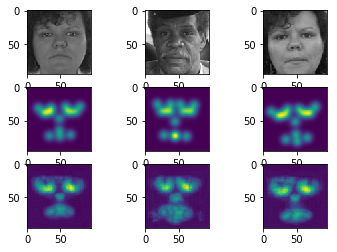

In [ ]:
show_masks(imgs[0:3], masks[0:3], nrows=3, ncols=3, include_preds=True, predictions = preds)

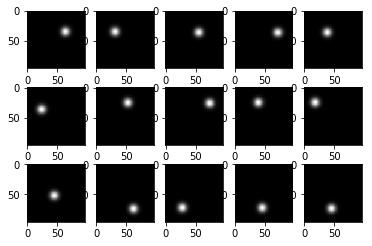

In [ ]:
gt_mask = masks[1]
gt_mask = np.reshape(gt_mask, newshape=(96,96,15))
showAllMasks(gt_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

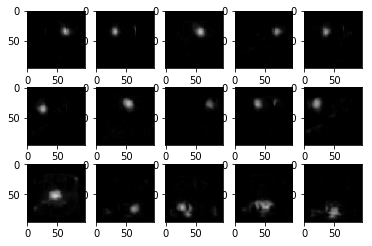

In [ ]:
pred_mask = preds[1]
pred_mask = np.reshape(pred_mask, newshape=(96,96,15))
showAllMasks(pred_mask)

#### Get keypoints from masks

In [ ]:
kps_gt, kps_preds = calcKeypoints(unet, val_gen)

In [ ]:
print(kps_preds.shape)
print(kps_gt.shape)

(22, 30)
(22, 30)


#### Qualitative keypoint results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


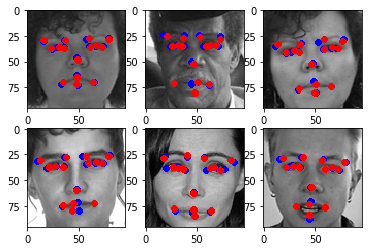

In [ ]:
show_keypoints(imgs[0:6], kps_gt[0:6], nrows=2, ncols=3, predictions=kps_preds[0:6])

#### Calculate RMS Error

In [ ]:
rms_error = calcRMSError(kps_gt, kps_preds)
print("Validation RMS Error = {}".format(rms_error))

Validation RMS Error = 4.449719092257398


### FCN8

#### Qualitative Mask Results

In [ ]:
imgs, masks = val_gen[0]
fcn.load_weights("fcn1.h5")
preds = fcn.predict_on_batch(imgs)

In [ ]:
print(preds.shape)
print(masks.shape)

(16, 138240, 1)
(16, 138240, 1)


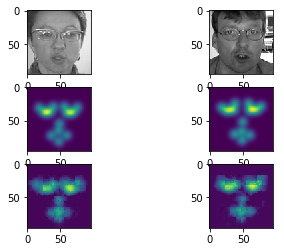

In [ ]:
show_masks(imgs[0:2], masks[0:2], nrows=3, ncols=2, include_preds=True, predictions = preds)

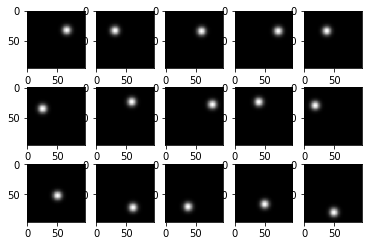

In [ ]:
gt_mask = masks[1]
gt_mask = np.reshape(gt_mask, newshape=(96,96,15))
showAllMasks(gt_mask)

In [ ]:
print(np.unravel_index(np.argmax(gt_mask[:, :, 0], axis=None), dims=(96,96)))

(33, 65)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

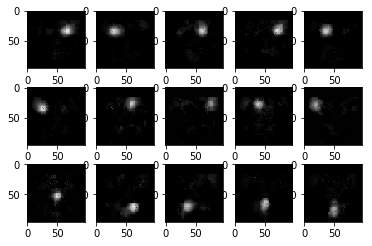

In [ ]:
pred_mask = preds[1]
pred_mask = np.reshape(pred_mask, newshape=(96,96,15))
showAllMasks(pred_mask)

In [ ]:
print(np.unravel_index(np.argmax(pred_mask[:, :, 0], axis=None), dims=(96,96)))

(33, 66)


#### Get Keypoints from Results

In [ ]:
kps_gt, kps_preds = calcKeypoints(fcn, val_gen)

In [ ]:
print(kps_preds.shape)
print(kps_gt.shape)

(22, 30)
(22, 30)


#### Qualitative keypoint results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


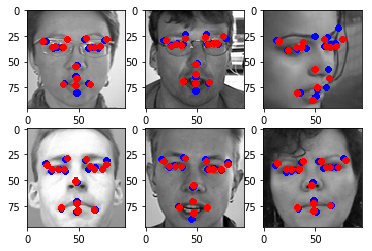

In [ ]:
show_keypoints(imgs[0:6], kps_gt[0:6], nrows=2, ncols=3, predictions=kps_preds[0:6])

In [ ]:
print(kps_preds[1])

[66. 33. 30. 34. 61. 34. 70. 33. 35. 35. 25. 36. 58. 27. 76. 26. 39. 28.
 20. 30. 49. 53. 62. 71. 37. 70. 49. 63. 49. 72.]


In [ ]:
print(kps_gt[1])

[65. 33. 31. 33. 60. 34. 71. 34. 37. 34. 25. 35. 59. 24. 78. 28. 39. 24.
 18. 30. 50. 52. 61. 72. 38. 70. 49. 66. 49. 79.]


#### Calculate RMS Error

In [ ]:
rms_error = calcRMSError(kps_gt, kps_preds)
print("Validation RMS Error = {}".format(rms_error))

Validation RMS Error = 3.063964553952736
